In [1]:
import torch
import torchvision.models as models

from neural_style import run_style_transfer

%matplotlib inline

In [2]:
idx = 1
path = 'examples/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)

In [18]:
import torch
from PIL import Image
from skimage.transform import resize
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def tensor_to_image(x):
    """
    Transforms torch.Tensor to np.array
        (1, C, W, H) -> (W, H, C)
        (B, C, W, H) -> (B, W, H, C) 

    """
    return x.cpu().detach().numpy().transpose(0, 2, 3, 1).squeeze().clip(0, 1)


def image_to_tensor(x):
    """
    Transforms np.array to torch.Tensor
        (W, H)       -> (1, 1, W, H)
        (W, H, C)    -> (1, C, W, H)
        (B, W, H, C) -> (B, C, W, H)

    """
    if x.ndim == 2:
        return torch.cuda.FloatTensor(x).unsqueeze(0).unsqueeze(0)
    if x.ndim == 3:
        return torch.cuda.FloatTensor(x.transpose(2, 0, 1)).unsqueeze(0)
    if x.ndim == 4:
        return torch.cuda.FloatTensor(x.transpose(0, 3, 1, 2))
    raise RuntimeError("np.array's ndim is out of range 2, 3 or 4.")


def extract_masks(segment):
    """
    Extracts the segmentation masks from the segmentated image.
    Allowed colors are:
        blue, green, black, white, red,
        yellow, grey, light_blue, purple.
    """
    extracted_colors = []

    # BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREEN
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # BLACK
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # WHITE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # RED
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # YELLOW
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREY
    mask_r = (segment[..., 0] > 0.4) & (segment[..., 0] < 0.6)
    mask_g = (segment[..., 1] > 0.4) & (segment[..., 1] < 0.6)
    mask_b = (segment[..., 2] > 0.4) & (segment[..., 2] < 0.6)
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # LIGHT_BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # PURPLE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    return extracted_colors


def get_all_masks(path):
    """
    Returns the segmentation masks from the segmentated image.
    """
    image = Image.open(path)
    np_image = np.array(image, dtype=np.float) / 255
    return extract_masks(np_image)


def is_nonzero(mask, thrs=0.01):
    """
    Checks segmentation mask is dense.
    """
    return np.sum(mask) / mask.size > thrs


def get_masks(path_style, path_content):
    """
    Returns the meaningful segmentation masks.
    Avoides "orphan semantic labels" problem.
    """
    masks_style = get_all_masks(path_style)
    masks_content = get_all_masks(path_content)

    non_zero_masks = [
        is_nonzero(mask_c) and is_nonzero(mask_s)
        for mask_c, mask_s in zip(masks_content, masks_style)
    ]

    masks_style = [mask for mask, cond in zip(masks_style, non_zero_masks) if cond]
    masks_content = [mask for mask, cond in zip(masks_content, non_zero_masks) if cond]

    return masks_style, masks_content


def resize_masks(masks_style, masks_content, size):
    """
    Resizes masks to given size.
    """
    resize_mask = lambda mask: resize(mask, size, mode="reflect")

    masks_style = [resize_mask(mask) for mask in masks_style]
    masks_content = [resize_mask(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_to_tensor(masks_style, masks_content):
    """
    Transforms masks to torch.Tensor from np.array.
    """
    masks_style = [image_to_tensor(mask) for mask in masks_style]
    masks_content = [image_to_tensor(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_loader(path_style, path_content, size):
    """
    Loads masks.
    """
    style_masks, content_masks = get_masks(path_style, path_content)
    style_masks, content_masks = resize_masks(style_masks, content_masks, size)
    style_masks, content_masks = masks_to_tensor(style_masks, content_masks)

    return style_masks, content_masks


def image_loader(image_name, size):
    """
    Loads images.
    """
    loader = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image


def plt_images(
    style_img,
    output_img,
    content_img,
    style_title="Style Image",
    output_title="Output Image",
    content_title="Content Image",
):
    """
    Plots style, output and content images to ease comparison.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(tensor_to_image(style_img))
    plt.title("Style Image")

    plt.subplot(1, 3, 2)
    plt.imshow(tensor_to_image(output_img))
    plt.title("Output Image")

    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_image(content_img))
    plt.title("Content Image")

    plt.tight_layout()
    plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms

import copy

from closed_form_matting import compute_laplacian


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


class ContentLoss(nn.Module):
    """
    See Gatys et al. for the details.
    """

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    B, C, H, W = input.size()
    features = input.view(B * C, H * W)
    gram = torch.mm(features, features.t())

    return gram.div(B * C * H * W)


class StyleLoss(nn.Module):
    """
    See Gatys et al. for the details.
    """

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        gram = gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target)
        return input


class AugmentedStyleLoss(nn.Module):
    """
    AugmentedStyleLoss exploits the semantic information of images.
    See Luan et al. for the details.
    """

    def __init__(self, target_feature, target_masks, input_masks):
        super(AugmentedStyleLoss, self).__init__()
        self.input_masks = [mask.detach() for mask in input_masks]
        self.targets = [
            gram_matrix(target_feature * mask).detach() for mask in target_masks
        ]

    def forward(self, input):
        gram_matrices = [
            gram_matrix(input * mask.detach()) for mask in self.input_masks
        ]
        self.loss = sum(
            F.mse_loss(gram, target)
            for gram, target in zip(gram_matrices, self.targets)
        )
        return input


def get_style_model_and_losses(
    cnn,
    normalization_mean,
    normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    style_masks,
    content_masks,
    device,
):
    """
    Assumptions:
        - cnn is a nn.Sequential
        - resize happens only in the pooling layers
    """
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    num_pool, num_conv = 0, 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            num_conv += 1
            name = "conv{}_{}".format(num_pool, num_conv)

        elif isinstance(layer, nn.ReLU):
            name = "relu{}_{}".format(num_pool, num_conv)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            num_pool += 1
            num_conv = 0
            name = "pool_{}".format(num_pool)
            layer = nn.AvgPool2d(
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
            )

            # Update the segmentation masks to match
            # the activation matrices of the neural responses.
            style_masks = [layer(mask) for mask in style_masks]
            content_masks = [layer(mask) for mask in content_masks]

        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn{}_{}".format(num_pool, num_conv)

        else:
            raise RuntimeError(
                "Unrecognized layer: {}".format(layer.__class__.__name__)
            )

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(num_pool), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()

            style_loss = AugmentedStyleLoss(target_feature, style_masks, content_masks)
            model.add_module("style_loss_{}".format(num_pool), style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    # to speed up forward pass.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss, AugmentedStyleLoss)):
            break

    model = model[: (i + 1)]

    return model, style_losses, content_losses


def get_input_optimizer(input_img):
    optimizer = optim.Adam([input_img.requires_grad_()]) #LBFGS
    return optimizer


def run_style_transfer(
    cnn,
    normalization_mean,
    normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    input_img,
    style_masks,
    content_masks,
    device,
    reg=False,
    num_steps=300,
    style_weight=100000,
    content_weight=1000,
    reg_weight=1000,
):
    """
    Run the style transfer.
    `reg_weight` is the photorealistic regularization hyperparameter 
    """
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        normalization_mean,
        normalization_std,
        style_layers,
        content_layers,
        style_img,
        content_img,
        style_masks,
        content_masks,
        device,
    )
    optimizer = get_input_optimizer(input_img)

    if reg:
        L = compute_laplacian(tensor_to_image(content_img))

        def regularization_grad(input_img):
            """
            Photorealistic regularization
            See Luan et al. for the details.
            """
            im = tensor_to_image(input_img)
            grad = L.dot(im.reshape(-1, 3))
            loss = (grad * im.reshape(-1, 3)).sum()
            return loss, 2. * grad.reshape(*im.shape)

    step = 0
    while step <= num_steps:

        def closure():
            """
            https://pytorch.org/docs/stable/optim.html#optimizer-step-closure
            """
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            get_loss = lambda x: x.loss
            style_score = style_weight * sum(map(get_loss, style_losses))
            content_score = content_weight * sum(map(get_loss, content_losses))

            loss = style_score + content_score
            loss.backward()

            # Add photorealistic regularization
            if reg:
                reg_loss, reg_grad = regularization_grad(input_img)
                reg_grad_tensor = image_to_tensor(reg_grad)

                input_img.grad += reg_weight * reg_grad_tensor

                loss += reg_weight * reg_loss

            nonlocal step
            step += 1

            if step % 50 == 0:
                print(
                    "step {:>4d}:".format(step),
                    "S: {:.3f} C: {:.3f} R:{:.3f}".format(
                        style_score.item(), content_score.item(), reg_loss if reg else 0
                    ),
                )

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

#### Get images

In [26]:
style_img = image_loader(path + 'style/tar{}.png'.format(idx), imsize).to(device, torch.float)
content_img = image_loader(path + 'input/in{}.png'.format(idx), imsize).to(device, torch.float)
input_img = content_img.clone()

style_masks, content_masks = masks_loader(
    path + 'segmentation/tar{}.png'.format(idx),
    path + 'segmentation/in{}.png'.format(idx),
    imsize)

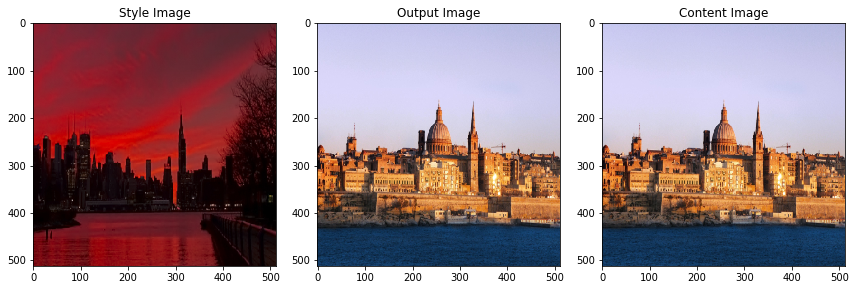

In [27]:
plt_images(style_img.cpu(), input_img.cpu(), content_img.cpu())

#### Load model

VGG is trained with the following normalization. We use it to normalize our images as well.

In [28]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
content_layers = ["conv4_2"]

- - - 

### Pipeline

First, we perform the style transfer without the photorealistic regularization then we add the regularization term.

#### reg=False, num_steps=500

In [33]:
%%time

output = run_style_transfer(
    vgg,
    vgg_normalization_mean,
    vgg_normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    input_img,
    style_masks,
    content_masks,
    device,
    reg=False,
    style_weight=1e6,
    content_weight=1e4,
    reg_weight=0,
    num_steps=1500,
)

step   50: S: 114.439 C: 2.965 R:0.000
step  100: S: 112.276 C: 2.326 R:0.000
step  150: S: 110.252 C: 2.241 R:0.000
step  200: S: 108.336 C: 2.230 R:0.000
step  250: S: 106.574 C: 2.189 R:0.000
step  300: S: 104.990 C: 2.213 R:0.000
step  350: S: 103.579 C: 2.261 R:0.000
step  400: S: 102.289 C: 2.158 R:0.000
step  450: S: 101.134 C: 2.214 R:0.000
step  500: S: 100.052 C: 2.460 R:0.000
step  550: S: 99.077 C: 2.155 R:0.000
step  600: S: 98.123 C: 2.235 R:0.000
step  650: S: 97.251 C: 2.173 R:0.000
step  700: S: 96.378 C: 2.302 R:0.000
step  750: S: 95.596 C: 2.175 R:0.000
step  800: S: 94.789 C: 2.124 R:0.000
step  850: S: 94.003 C: 2.113 R:0.000
step  900: S: 93.322 C: 2.728 R:0.000
step  950: S: 92.594 C: 2.106 R:0.000
step 1000: S: 91.877 C: 2.107 R:0.000
step 1050: S: 91.194 C: 2.713 R:0.000
step 1100: S: 90.538 C: 2.093 R:0.000
step 1150: S: 89.902 C: 2.429 R:0.000
step 1200: S: 89.324 C: 2.413 R:0.000
step 1250: S: 88.670 C: 2.072 R:0.000
step 1300: S: 88.106 C: 2.100 R:0.000
st

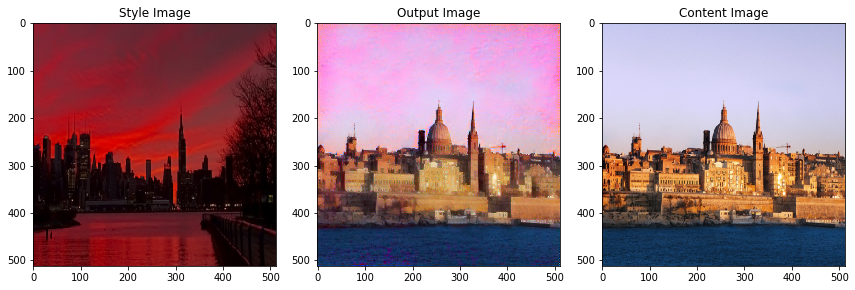

In [34]:
plt_images(style_img, input_img, content_img)

#### reg=True, num_steps=500

In [35]:
%%time

output = run_style_transfer(
    vgg,
    vgg_normalization_mean,
    vgg_normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    input_img,
    style_masks,
    content_masks,
    device,
    reg=True,
    style_weight=1e6,
    content_weight=1e4,
    reg_weight=1e-6,
    num_steps=1000,
)

step   50: S: 86.864 C: 2.903 R:2861.931
step  100: S: 86.094 C: 2.204 R:2866.969
step  150: S: 85.606 C: 2.111 R:2880.012
step  200: S: 85.205 C: 2.073 R:2898.817
step  250: S: 84.825 C: 2.067 R:2922.418
step  300: S: 84.454 C: 2.080 R:2950.091
step  350: S: 84.077 C: 2.055 R:2981.770
step  400: S: 83.696 C: 2.077 R:3017.242
step  450: S: 83.300 C: 2.105 R:3056.373
step  500: S: 82.916 C: 2.180 R:3099.464
step  550: S: 82.497 C: 2.068 R:3145.706
step  600: S: 82.084 C: 2.093 R:3194.936
step  650: S: 81.654 C: 2.107 R:3246.907
step  700: S: 81.225 C: 2.091 R:3301.932
step  750: S: 80.814 C: 2.419 R:3359.856
step  800: S: 80.358 C: 2.126 R:3418.987
step  850: S: 79.990 C: 2.234 R:3480.945
step  900: S: 79.469 C: 2.133 R:3542.990
step  950: S: 78.988 C: 2.159 R:3608.371
step 1000: S: 78.539 C: 2.158 R:3676.251
CPU times: user 6min 58s, sys: 1min 25s, total: 8min 24s
Wall time: 8min 30s


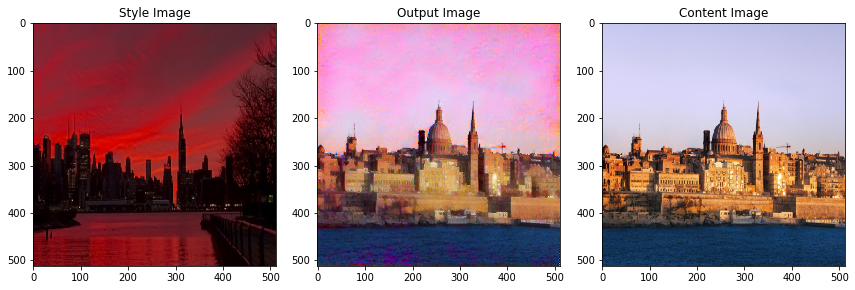

In [36]:
plt_images(style_img, input_img, content_img)